# EDA - AIRLINE DELAY PREDICTION PROJECT

---

## 0 - Importaciones

---

In [50]:
# Importaciones básicas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import imblearn

# Importaciones para procesamiento de datos y funcionales
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import json
from pickle import dump
import gc

# Importaciones para modelado
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgbm
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

pd.set_option('display.max_columns', None)


---

## 1 - Recolección de Datos

---

Como parte de la metodología y alcance del proyecto, nos enfocamos específicamente en el análisis del año 2021, a pesar de contar con datos históricos desde 2018 hasta 2022. Esta decisión se fundamenta en las limitaciones técnicas y de recursos computacionales disponibles, considerando el volumen significativo de información: cada año contiene aproximadamente 5 millones de registros distribuidos en 61 variables diferentes. No elegimos el año 2022 debido a que tiene informacion solo hasta mediados del mismo año.

La decisión de acotar el análisis a un único año representa un enfoque estratégico que nos permite realizar un análisis más profundo y detallado de los datos, optimizando los recursos computacionales disponibles sin comprometer la calidad y profundidad del análisis

In [51]:
#df_2018 = pd.read_parquet("../data/raw/Combined_Flights_2018.parquet")
#df_2019 = pd.read_parquet("../data/raw/Combined_Flights_2019.parquet", engine="pyarrow")
#df_2020 = pd.read_parquet("../data/raw/Combined_Flights_2020.parquet")
#df_2021 = pd.read_parquet("../data/raw/Combined_Flights_2021.parquet")
df = pd.read_parquet("../data/raw/Combined_Flights_2021.parquet")

In [52]:
'''data_frames = [df_2020, df_2021]
df = pd.concat(data_frames, ignore_index=True)'''

'data_frames = [df_2020, df_2021]\ndf = pd.concat(data_frames, ignore_index=True)'

In [53]:
df.head(3)

,FlightDate,Airline,Origin,Dest,Cancelled,Diverted,CRSDepTime,DepTime,DepDelayMinutes,DepDelay,ArrTime,ArrDelayMinutes,AirTime,CRSElapsedTime,ActualElapsedTime,Distance,Year,Quarter,Month,DayofMonth,DayOfWeek,Marketing_Airline_Network,Operated_or_Branded_Code_Share_Partners,DOT_ID_Marketing_Airline,IATA_Code_Marketing_Airline,Flight_Number_Marketing_Airline,Operating_Airline,DOT_ID_Operating_Airline,IATA_Code_Operating_Airline,Tail_Number,Flight_Number_Operating_Airline,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,OriginCityName,OriginState,OriginStateFips,OriginStateName,OriginWac,DestAirportID,DestAirportSeqID,DestCityMarketID,DestCityName,DestState,DestStateFips,DestStateName,DestWac,DepDel15,DepartureDelayGroups,DepTimeBlk,TaxiOut,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrDelay,ArrDel15,ArrivalDelayGroups,ArrTimeBlk,DistanceGroup,DivAirportLandings
0,2021-03-03,SkyWest Airlines Inc.,SGU,PHX,False,False,724,714.0,0.0,-10.0,818.0,0.0,49.0,79.0,64.0,262.0,2021,1,3,3,3,AA,AA_CODESHARE,19805,AA,3133,OO,20304,OO,N728SK,3133,14794,1479405,34794,"St. George, UT",UT,49,Utah,87,14107,1410702,30466,"Phoenix, AZ",AZ,4,Arizona,81,0.0,-1.0,0700-0759,10.0,724.0,813.0,5.0,843,-25.0,0.0,-2.0,0800-0859,2,0.0
1,2021-03-03,SkyWest Airlines Inc.,PHX,SGU,False,False,922,917.0,0.0,-5.0,1031.0,0.0,48.0,78.0,74.0,262.0,2021,1,3,3,3,AA,AA_CODESHARE,19805,AA,3134,OO,20304,OO,N752SK,3134,14107,1410702,30466,"Phoenix, AZ",AZ,4,Arizona,81,14794,1479405,34794,"St. George, UT",UT,49,Utah,87,0.0,-1.0,0900-0959,23.0,940.0,1028.0,3.0,1040,-9.0,0.0,-1.0,1000-1059,2,0.0
2,2021-03-03,SkyWest Airlines Inc.,MHT,ORD,False,False,1330,1321.0,0.0,-9.0,1501.0,0.0,129.0,180.0,160.0,843.0,2021,1,3,3,3,AA,AA_CODESHARE,19805,AA,3135,OO,20304,OO,N766SK,3135,13296,1329604,30721,"Manchester, NH",NH,33,New Hampshire,14,13930,1393007,30977,"Chicago, IL",IL,17,Illinois,41,0.0,-1.0,1300-1359,15.0,1336.0,1445.0,16.0,1530,-29.0,0.0,-2.0,1500-1559,4,0.0


---

## 2 - Exploracion de datos y limpieza de los mismo

---

In [54]:
print(f'Nuestro datframe contiene {len(df)} filas (rows) y tiene {df.shape[1]} columnas (features)')

Nuestro datframe contiene 6311871 filas (rows) y tiene 61 columnas (features)


Como parte de nuestra estrategia de optimización de recursos y eficiencia en el procesamiento de datos, implementamos una selección preliminar de características (feature selection) del dataset. Esta aproximación metodológica nos permitió enfocarnos específicamente en las variables más relevantes para nuestro análisis, reduciendo la dimensionalidad de los datos y optimizando el uso de recursos computacionales.
Esta decisión no solo facilitó un manejo más eficiente de la información, sino que también nos permitió concentrar nuestros esfuerzos analíticos en los aspectos más significativos del proyecto, garantizando así la calidad y precisión de nuestros resultados

### 2.1 - Seleccion preliminar de caracteristicas (feature selection)

In [55]:
print(df.columns)

Index(['FlightDate', 'Airline', 'Origin', 'Dest', 'Cancelled', 'Diverted',
       'CRSDepTime', 'DepTime', 'DepDelayMinutes', 'DepDelay', 'ArrTime',
       'ArrDelayMinutes', 'AirTime', 'CRSElapsedTime', 'ActualElapsedTime',
       'Distance', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek',
       'Marketing_Airline_Network', 'Operated_or_Branded_Code_Share_Partners',
       'DOT_ID_Marketing_Airline', 'IATA_Code_Marketing_Airline',
       'Flight_Number_Marketing_Airline', 'Operating_Airline',
       'DOT_ID_Operating_Airline', 'IATA_Code_Operating_Airline',
       'Tail_Number', 'Flight_Number_Operating_Airline', 'OriginAirportID',
       'OriginAirportSeqID', 'OriginCityMarketID', 'OriginCityName',
       'OriginState', 'OriginStateFips', 'OriginStateName', 'OriginWac',
       'DestAirportID', 'DestAirportSeqID', 'DestCityMarketID', 'DestCityName',
       'DestState', 'DestStateFips', 'DestStateName', 'DestWac', 'DepDel15',
       'DepartureDelayGroups', 'DepTimeBlk', 'TaxiOu

#### Información redundante o irrelevante para el objetivo
Estas columnas no aportan valor predictivo o contienen información que no estará disponible antes del despegue.

| **Columna(s)**                                                                                                         | **Descripción**                                                                                              |
|------------------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------|
| **'DepTime', 'DepDelayMinutes', 'DepDelay'**                                                                             | Dependen del retraso real al momento de la salida, que es lo que queremos predecir.                         |
| **'ArrTime', 'ArrDelayMinutes', 'AirTime', 'ActualElapsedTime', 'ArrDelay', 'ArrDel15', 'ArrivalDelayGroups'**           | Información posterior al despegue.                                                                          |
| **'Cancelled', 'Diverted', 'DivAirportLandings'**                                                                        | Indican si el vuelo fue cancelado o desviado, lo cual no es útil para predecir retrasos antes del despegue.  |
| **'WheelsOff', 'WheelsOn', 'TaxiOut', 'TaxiIn'**                                                                         | Información posterior al despegue.                                                                          |
| **'Tail_Number'**                                                                                                        | No aporta información relevante y puede introducir ruido.                                                   |
| **'OriginAirportID', 'OriginAirportSeqID', 'OriginCityMarketID', 'DestAirportID', 'DestAirportSeqID', 'DestCityMarketID'**| IDs redundantes que pueden ser reemplazados con información más significativa como el nombre del aeropuerto o la ciudad. |
| **'OriginWac', 'DestWac'**                                                                                               | Códigos geográficos redundantes.                                                                            |



#### Información que podría ser útil pero requiere validación
Estas columnas pueden tener correlación con retrasos, pero debemos evaluar su utilidad.

| **Columna(s)**                                                                                                         | **Descripción**                                                                                              |
|------------------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------|
| **'FlightDate'**                                                                                                         | Podría ser relevante si no tuviesemos ya las columnas divididas hablando del tiempo                       |
| **'Flight_Number_Marketing_Airline', 'Flight_Number_Operating_Airline'**                                                 | Dato granular que podría ser redundante con la aerolínea y menos práctico para usuarios en una página web.   |
| **'Marketing_Airline_Network', 'Operated_or_Branded_Code_Share_Partners'**                                               | Podrían correlacionarse con retrasos, pero hay que evitar redundancia con otras columnas relacionadas a la aerolínea. |
| **'DOT_ID_Marketing_Airline', 'DOT_ID_Operating_Airline', 'IATA_Code_Marketing_Airline', 'IATA_Code_Operating_Airline'** | IDs redundantes con el nombre de la aerolínea.                                                              |
| **'DistanceGroup'**                                                                                                      | Es categórica, pero podría ser redundante con **'Distance'**.                                                 |
| **'DepartureDelayGroups'**                                                                                               | Representa rangos de retrasos, pero depende del retraso real, por lo que no será útil.                      |



#### Información clave para el modelo
Estas columnas probablemente tendrán mayor impacto en la predicción.

| **Columna(s)**                                                                 | **Descripción**                                                                                         |
|--------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------|
| **'Airline', 'Operating_Airline'**                                               | Las aerolíneas pueden tener diferentes tasas de puntualidad.                                           |
| **'Origin', 'Dest', 'OriginCityName', 'DestCityName', 'OriginStateName', 'DestStateName'**| Lugares de origen y destino son cruciales, ya que algunos aeropuertos tienen mayores tasas de retraso. |
| **'CRSDepTime', 'CRSArrTime'**                       | Hora programada y bloque horario pueden correlacionarse con la congestión del aeropuerto y los retrasos.|
| **'Distance'**                                                                   | La distancia entre el origen y el destino puede afectar la probabilidad de retrasos.                   |
| **'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek'**                        | Información temporal que puede capturar tendencias estacionales o semanales.                           |



### 2.2 - Propuesta de columnas finales
Variables seleccionadas para el modelo.

| **Columna(s)**             | **Descripción**                               |
|----------------------------|-----------------------------------------------|
| **'Airline' (o 'Operating_Airline')** | Aerolínea del vuelo.                         |
| **'Origin'**                 | Aeropuerto de origen.                        |
| **'Dest'**                   | Aeropuerto de destino.                       |
| **'OriginCityName'**         | Ciudad de origen.                            |
| **'DestCityName'**           | Ciudad de destino.                           |
| **'OriginStateName'**            | Estado de origen.                            |
| **'DestStateName'**              | Estado de destino.                           |
| **'CRSDepTime'**             | Hora programada de salida.                   |
| **'CRSArrTime'**             | Hora programada de llegada.                   |
| **'Distance'**               | Distancia entre origen y destino.            |
| **'Year'**                   | Año del vuelo.                               |
| **'Quarter'**                | Trimestre del vuelo.                         |
| **'Month'**                  | Mes del vuelo.                               |
| **'DayofMonth'**             | Día del mes del vuelo.                       |
| **'DayOfWeek'**              | Día de la semana del vuelo.                  |
| **'DepDel15'**               | Variable predictora para clasificacion                  |
| **'DepDelayMinutes'**               | Variable predictora para regresion                  |

In [56]:
columnas_finales = [
    # Features
    'FlightDate', 'Airline', 'Origin', 'Dest', 'OriginCityName', 'DestCityName',
    'OriginStateName', 'DestStateName', 'CRSDepTime', 'CRSArrTime', 'Distance',
    'Quarter', 'Month', 'DayofMonth', 'DayOfWeek',
    
    # Targets
    'DepDel15', 'DepDelay'
]

In [57]:
df = df[columnas_finales]
df.head(3)

,FlightDate,Airline,Origin,Dest,OriginCityName,DestCityName,OriginStateName,DestStateName,CRSDepTime,CRSArrTime,Distance,Quarter,Month,DayofMonth,DayOfWeek,DepDel15,DepDelay
0,2021-03-03,SkyWest Airlines Inc.,SGU,PHX,"St. George, UT","Phoenix, AZ",Utah,Arizona,724,843,262.0,1,3,3,3,0.0,-10.0
1,2021-03-03,SkyWest Airlines Inc.,PHX,SGU,"Phoenix, AZ","St. George, UT",Arizona,Utah,922,1040,262.0,1,3,3,3,0.0,-5.0
2,2021-03-03,SkyWest Airlines Inc.,MHT,ORD,"Manchester, NH","Chicago, IL",New Hampshire,Illinois,1330,1530,843.0,1,3,3,3,0.0,-9.0


In [58]:
#Conclusión
print("Se han eliminado características redundantes y seleccionado variables clave para la predicción. \n\
El dataset ahora contiene {} filas y {} columnas listas para la modelización.".format(df.shape[0], df.shape[1]))

Se han eliminado características redundantes y seleccionado variables clave para la predicción. 
El dataset ahora contiene 6311871 filas y 17 columnas listas para la modelización.


### 2.3 - Estructura de los datos

En esta sección, procederemos a realizar un análisis estadístico descriptivo exhaustivo de las variables seleccionadas. Este análisis nos permitirá comprender en profundidad la distribución, tendencias centrales y dispersión de nuestros datos, proporcionando una base sólida para las subsiguientes etapas de modelado y análisis predictivo

In [59]:
#Información básica del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6311871 entries, 0 to 573778
Data columns (total 17 columns):
 #   Column           Dtype         
---  ------           -----         
 0   FlightDate       datetime64[us]
 1   Airline          object        
 2   Origin           object        
 3   Dest             object        
 4   OriginCityName   object        
 5   DestCityName     object        
 6   OriginStateName  object        
 7   DestStateName    object        
 8   CRSDepTime       int64         
 9   CRSArrTime       int64         
 10  Distance         float64       
 11  Quarter          int64         
 12  Month            int64         
 13  DayofMonth       int64         
 14  DayOfWeek        int64         
 15  DepDel15         float64       
 16  DepDelay         float64       
dtypes: datetime64[us](1), float64(3), int64(6), object(7)
memory usage: 866.8+ MB


In [60]:
#Estadísticos descriptivos
df.describe()

,FlightDate,CRSDepTime,CRSArrTime,Distance,Quarter,Month,DayofMonth,DayOfWeek,DepDel15,DepDelay
count,6311871,6.311871e+06,6.311871e+06,6.311871e+06,6.311871e+06,6.311871e+06,6.311871e+06,6.311871e+06,6.203458e+06,6.203458e+06
mean,2021-07-15 12:56:53.561019,1.323953e+03,1.498272e+03,7.955762e+02,2.650051e+00,6.969905e+00,1.579259e+01,4.013676e+00,1.731723e-01,9.468347e+00
min,2021-01-01 00:00:00,1.000000e+00,1.000000e+00,3.100000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,-1.050000e+02
25%,2021-04-25 00:00:00,9.200000e+02,1.118000e+03,3.700000e+02,2.000000e+00,4.000000e+00,8.000000e+00,2.000000e+00,0.000000e+00,-6.000000e+00
50%,2021-07-20 00:00:00,1.315000e+03,1.520000e+03,6.460000e+02,3.000000e+00,7.000000e+00,1.600000e+01,4.000000e+00,0.000000e+00,-2.000000e+00
75%,2021-10-10 00:00:00,1.723000e+03,1.914000e+03,1.033000e+03,4.000000e+00,1.000000e+01,2.300000e+01,6.000000e+00,0.000000e+00,6.000000e+00
max,2021-12-31 00:00:00,2.359000e+03,2.400000e+03,5.812000e+03,4.000000e+00,1.200000e+01,3.100000e+01,7.000000e+00,1.000000e+00,3.095000e+03
std,NaN,4.741972e+02,4.946565e+02,5.832931e+02,1.077919e+00,3.300914e+00,8.786535e+00,2.006264e+00,3.783962e-01,4.837844e+01


### 2.4 - Limpieza de los datos (duplicados y vacios)

In [61]:
#Verificar y eliminar duplicados
duplicates = df.duplicated().sum()
print("Número de filas duplicadas antes de limpieza:", duplicates)

#Eliminando valores duplicados
df.drop_duplicates(inplace=True)

print("\nValores duplicados eliminados!")

Número de filas duplicadas antes de limpieza: 5

Valores duplicados eliminados!


In [62]:
#Encontrando valores NaN
print(f"Valores NaN encontrados: \n'Columnas'       'Cantidad'\n{df.isna().sum()[df.isna().sum()>0]}")

#Eliminando valores duplicados
df.dropna(inplace=True)

print("\nValores NaN eliminados!")

Valores NaN encontrados: 
'Columnas'       'Cantidad'
DepDel15    108412
DepDelay    108412
dtype: int64

Valores NaN eliminados!


In [63]:
#Conclusión rápida
print("Conclusión: Se han eliminado duplicados y valores nulos, asegurando que el dataset esté limpio\ny listo para el análisis posterior. \
Ahora el dataset contiene {} filas y {} columnas.".format(df.shape[0], df.shape[1]))

Conclusión: Se han eliminado duplicados y valores nulos, asegurando que el dataset esté limpio
y listo para el análisis posterior. Ahora el dataset contiene 6203454 filas y 17 columnas.


---

## 3 - Dividiendo el dataset

---

### 3.1 - Dividiendo el dataset en variables categóricas y numéricas

In [64]:
# Understanding how many type of features we have
print(f"Estos son los tipos de datos que tenemos en nuestro data set: {df.dtypes.unique()}")

Estos son los tipos de datos que tenemos en nuestro data set: [dtype('<M8[us]') dtype('O') dtype('int64') dtype('float64')]


In [65]:
# Separar variables numéricas y categóricas
num = ["float64", "int64"]
cat = ['O']

df_num = df.select_dtypes(num)
df_cat = df.select_dtypes(cat)

In [66]:
print(f'Columnas dentro de nuestras variables "Numericas": {df_num.columns.tolist()}')
print(f'Columnas dentro de nuestras variables "Categoricas": {df_cat.columns.tolist()}')

Columnas dentro de nuestras variables "Numericas": ['CRSDepTime', 'CRSArrTime', 'Distance', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'DepDel15', 'DepDelay']
Columnas dentro de nuestras variables "Categoricas": ['Airline', 'Origin', 'Dest', 'OriginCityName', 'DestCityName', 'OriginStateName', 'DestStateName']


---

## 4 - Análisis Univariado

---

### 4.1 - Análisis de Variables Categóricas

In [67]:
'''fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(12,20))
sns.set_palette("bright")

# Graficar las principales variables categóricas
categorical_vars = ['Airline', 'OriginStateName', 'DestStateName', 'OriginCityName', 'DestCityName']
for i, var in enumerate(df_cat.columns):
    top_values = df[var].value_counts().head(20)
    sns.barplot(ax=axes[i], y=top_values.index, x=top_values.values, hue=top_values.index, dodge=False)
    axes[i].set_title(f"Distribución de {var}", fontsize=14, fontweight='bold')
    axes[i].set_xlabel("Frecuencia")
    axes[i].set_ylabel(var)
    axes[i].tick_params(axis='y', labelsize=7)

plt.tight_layout()
plt.show()'''

'fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(12,20))\nsns.set_palette("bright")\n\n# Graficar las principales variables categóricas\ncategorical_vars = [\'Airline\', \'OriginStateName\', \'DestStateName\', \'OriginCityName\', \'DestCityName\']\nfor i, var in enumerate(df_cat.columns):\n    top_values = df[var].value_counts().head(20)\n    sns.barplot(ax=axes[i], y=top_values.index, x=top_values.values, hue=top_values.index, dodge=False)\n    axes[i].set_title(f"Distribución de {var}", fontsize=14, fontweight=\'bold\')\n    axes[i].set_xlabel("Frecuencia")\n    axes[i].set_ylabel(var)\n    axes[i].tick_params(axis=\'y\', labelsize=7)\n\nplt.tight_layout()\nplt.show()'

### 4.2 - Análisis de Variables Numéricas

In [68]:
'''# Configurar visualización
df_sample = df.sample(frac=0.5, random_state=42)
fig, axes = plt.subplots(nrows=9, ncols=1, figsize=(10, 20))


for i, var in enumerate(df_num.columns):
    sns.histplot(df_sample[var], ax=axes[i], kde=True, bins=30, color="royalblue")
    axes[i].set_title(f"Distribución de {var}", fontsize=12, fontweight='bold')
    axes[i].set_xlabel(var)

plt.tight_layout()
plt.show()
'''

'# Configurar visualización\ndf_sample = df.sample(frac=0.5, random_state=42)\nfig, axes = plt.subplots(nrows=9, ncols=1, figsize=(10, 20))\n\n\nfor i, var in enumerate(df_num.columns):\n    sns.histplot(df_sample[var], ax=axes[i], kde=True, bins=30, color="royalblue")\n    axes[i].set_title(f"Distribución de {var}", fontsize=12, fontweight=\'bold\')\n    axes[i].set_xlabel(var)\n\nplt.tight_layout()\nplt.show()\n'

In [69]:
'''fig, ax = plt.subplots(8, 2, figsize=(10,12), gridspec_kw={"height_ratios":[6,1,6,1,6,1,6,1]})
sns.reset_defaults()

#Row_1
sns.histplot(ax = ax[0,0], data=df_num, x="DayOfWeek")
sns.boxplot(ax = ax[1,0], data=df_num, x="DayOfWeek")
sns.histplot(ax = ax[0,1], data=df_num, x="Month").set(ylabel=None)
sns.boxplot(ax = ax[1,1], data=df_num, x="Month")

#Row_2
sns.histplot(ax = ax[2,0], data=df_num, x="Quarter")
sns.boxplot(ax = ax[3,0], data=df_num, x="Quarter")
sns.histplot(ax = ax[2,1], data=df_num, x="DayofMonth").set(ylabel=None)
sns.boxplot(ax = ax[3,1], data=df_num, x="DayofMonth")

#Row_3
sns.histplot(ax = ax[4,0], data=df_num[(df_num["DepDelay"] >= 1) & (df_num["DepDelay"] <= 60)], x="DepDelay")
sns.boxplot(ax = ax[5,0], data=df_num, x="DepDelay")
sns.histplot(ax = ax[4,1], data=df_num, x="CRSDepTime").set(ylabel=None)
sns.boxplot(ax = ax[5,1], data=df_num, x="CRSDepTime")


#Row_4
sns.histplot(ax = ax[6,0], data=df_num, x="CRSArrTime")
sns.boxplot(ax = ax[7,0], data=df_num, x="CRSArrTime")
sns.histplot(ax = ax[6,1], data=df_num[df["Distance"] <= 2000], x="Distance")
sns.boxplot(ax = ax[7,1], data=df_num, x="Distance")

plt.tight_layout()
fig.subplots_adjust(hspace=1)
plt.show()'''

'fig, ax = plt.subplots(8, 2, figsize=(10,12), gridspec_kw={"height_ratios":[6,1,6,1,6,1,6,1]})\nsns.reset_defaults()\n\n#Row_1\nsns.histplot(ax = ax[0,0], data=df_num, x="DayOfWeek")\nsns.boxplot(ax = ax[1,0], data=df_num, x="DayOfWeek")\nsns.histplot(ax = ax[0,1], data=df_num, x="Month").set(ylabel=None)\nsns.boxplot(ax = ax[1,1], data=df_num, x="Month")\n\n#Row_2\nsns.histplot(ax = ax[2,0], data=df_num, x="Quarter")\nsns.boxplot(ax = ax[3,0], data=df_num, x="Quarter")\nsns.histplot(ax = ax[2,1], data=df_num, x="DayofMonth").set(ylabel=None)\nsns.boxplot(ax = ax[3,1], data=df_num, x="DayofMonth")\n\n#Row_3\nsns.histplot(ax = ax[4,0], data=df_num[(df_num["DepDelay"] >= 1) & (df_num["DepDelay"] <= 60)], x="DepDelay")\nsns.boxplot(ax = ax[5,0], data=df_num, x="DepDelay")\nsns.histplot(ax = ax[4,1], data=df_num, x="CRSDepTime").set(ylabel=None)\nsns.boxplot(ax = ax[5,1], data=df_num, x="CRSDepTime")\n\n\n#Row_4\nsns.histplot(ax = ax[6,0], data=df_num, x="CRSArrTime")\nsns.boxplot(ax = ax

### 4.3 - Análisis Categórico-Categórico

In [70]:
'''fig, axis = plt.subplots(3, 1, figsize = (10, 20))

sns.barplot(ax= axis[0], data=df, y='Airline', x='DepDelay')
sns.barplot(ax= axis[1], data=df, y='OriginStateName', x='DepDelay')
sns.barplot(ax= axis[2], data=df, y='DestStateName', x='DepDelay')

axis[0].set_title("Promedio de tiempo de Delays por Aerolínea", fontsize=14, fontweight='bold')
axis[1].set_title("Promedio de tiempo de Delays por lugar de origen", fontsize=14, fontweight='bold')
axis[2].set_title("Promedio de tiempo de Delays por lugar de llegada", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()'''

'fig, axis = plt.subplots(3, 1, figsize = (10, 20))\n\nsns.barplot(ax= axis[0], data=df, y=\'Airline\', x=\'DepDelay\')\nsns.barplot(ax= axis[1], data=df, y=\'OriginStateName\', x=\'DepDelay\')\nsns.barplot(ax= axis[2], data=df, y=\'DestStateName\', x=\'DepDelay\')\n\naxis[0].set_title("Promedio de tiempo de Delays por Aerolínea", fontsize=14, fontweight=\'bold\')\naxis[1].set_title("Promedio de tiempo de Delays por lugar de origen", fontsize=14, fontweight=\'bold\')\naxis[2].set_title("Promedio de tiempo de Delays por lugar de llegada", fontsize=14, fontweight=\'bold\')\n\nplt.tight_layout()\nplt.show()'

### 4.4 - Análisis de Categorias de Delay

In [71]:
df['DelayCategory'] = None
df.loc[df['DepDelay'] <= 0, 'DelayCategory'] = 'OnTime_Early'
df.loc[(df['DepDelay'] > 0) & (df['DepDelay'] <= 15), 'DelayCategory'] = 'Small_Delay'
df.loc[(df['DepDelay'] > 15) & (df['DepDelay'] <= 45), 'DelayCategory'] = 'Medium_Delay'
df.loc[df['DepDelay'] > 45, 'DelayCategory'] = 'Large_Delay'

print(df['DelayCategory'].value_counts())

DelayCategory
OnTime_Early    4147764
Small_Delay     1019416
Medium_Delay     563238
Large_Delay      473036
Name: count, dtype: int64


In [72]:
'''f,ax=plt.subplots(1,2,figsize=(20,8))
df['DelayCategory'].value_counts().plot.pie(explode=[0,0,0,0],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('DelayCategory')
ax[0].set_ylabel('')
sns.countplot(data=df,x = 'DelayCategory',order = df['DelayCategory'].value_counts().index,ax=ax[1])
ax[1].set_title('DelayCategory')
plt.show()
plt.savefig("Delay Category.png")

print('DelayCategory representa si el vuelo estuvo A Tiempo o Temprano (OnTime_Early), retrasado hasta 15 minutos (Small_Delay), retrasado hasta 45 minutos (Medium_Delay), retrasado más de 45 minutos (Large_Delay).')'''

'f,ax=plt.subplots(1,2,figsize=(20,8))\ndf[\'DelayCategory\'].value_counts().plot.pie(explode=[0,0,0,0],autopct=\'%1.1f%%\',ax=ax[0],shadow=True)\nax[0].set_title(\'DelayCategory\')\nax[0].set_ylabel(\'\')\nsns.countplot(data=df,x = \'DelayCategory\',order = df[\'DelayCategory\'].value_counts().index,ax=ax[1])\nax[1].set_title(\'DelayCategory\')\nplt.show()\nplt.savefig("Delay Category.png")\n\nprint(\'DelayCategory representa si el vuelo estuvo A Tiempo o Temprano (OnTime_Early), retrasado hasta 15 minutos (Small_Delay), retrasado hasta 45 minutos (Medium_Delay), retrasado más de 45 minutos (Large_Delay).\')'

### 4.4 - Análisis Numérico-Numérico

In [73]:
'''# Tomar muestra y pre-calcular correlaciones
df_sample = df_num.sample(frac=0.5, random_state=42)
corr_matrix = df_num.corr()

fig, axis = plt.subplots(4, 4, figsize=(20, 20))

# DayOfWeek
sns.regplot(ax=axis[0, 0], data=df_sample, x="DayOfWeek", y="DepDel15", 
            scatter_kws={'alpha':0.3}, n_boot=100)
sns.heatmap(corr_matrix.loc[["DepDel15"], ["DayOfWeek"]].T, 
            annot=True, fmt=".2f", ax=axis[1, 0], cbar=False)

# Month
sns.regplot(ax=axis[0, 1], data=df_sample, x="Month", y="DepDel15", 
            color=sns.color_palette("colorblind")[2], scatter_kws={'alpha':0.3}, n_boot=100)
sns.heatmap(corr_matrix.loc[["DepDel15"], ["Month"]].T, 
            annot=True, fmt=".2f", ax=axis[1, 1])

# Quarter
sns.regplot(ax=axis[0, 2], data=df_sample, x="Quarter", y="DepDel15", 
            color=sns.color_palette("colorblind")[3], scatter_kws={'alpha':0.3}, n_boot=100)
sns.heatmap(corr_matrix.loc[["DepDel15"], ["Quarter"]].T, 
            annot=True, fmt=".2f", ax=axis[1, 2])

# DayofMonth
sns.regplot(ax=axis[0, 3], data=df_sample, x="DayofMonth", y="DepDel15", 
            color=sns.color_palette("colorblind")[4], scatter_kws={'alpha':0.3}, n_boot=100)
sns.heatmap(corr_matrix.loc[["DepDel15"], ["DayofMonth"]].T, 
            annot=True, fmt=".2f", ax=axis[1, 3])

# DepTime
sns.regplot(ax=axis[2, 0], data=df_sample, x="CRSDepTime", y="DepDel15", 
            color=sns.color_palette("colorblind")[5], scatter_kws={'alpha':0.3}, n_boot=100)
sns.heatmap(corr_matrix.loc[["DepDel15"], ["CRSDepTime"]].T, 
            annot=True, fmt=".2f", ax=axis[3, 0])

# CRSDepTime
sns.regplot(ax=axis[2, 1], data=df_sample, x="CRSArrTime", y="DepDel15", 
            color=sns.color_palette("colorblind")[6], scatter_kws={'alpha':0.3}, n_boot=100)
sns.heatmap(corr_matrix.loc[["DepDel15"], ["CRSArrTime"]].T, 
            annot=True, fmt=".2f", ax=axis[3, 1])

# Distance
sns.regplot(ax=axis[2, 2], data=df_sample, x="Distance", y="DepDel15", 
            color=sns.color_palette("colorblind")[7], scatter_kws={'alpha':0.3}, n_boot=100)
sns.heatmap(corr_matrix.loc[["DepDel15"], ["Distance"]].T, 
            annot=True, fmt=".2f", ax=axis[3, 2])

# Ocultar los subplots vacíos
axis[2, 3].set_visible(False)
axis[3, 3].set_visible(False)

# Ajustar títulos
axis[0, 0].set_title("Day of Week vs Delay", fontsize=12)
axis[0, 1].set_title("Month vs Delay", fontsize=12)
axis[0, 2].set_title("Quarter vs Delay", fontsize=12)
axis[0, 3].set_title("Day of Month vs Delay", fontsize=12)
axis[2, 0].set_title("Departure Time vs Delay", fontsize=12)
axis[2, 1].set_title("Scheduled Departure Time vs Delay", fontsize=12)
axis[2, 2].set_title("Distance vs Delay", fontsize=12)

# Ajustar el diseño
plt.tight_layout()
plt.show()'''

'# Tomar muestra y pre-calcular correlaciones\ndf_sample = df_num.sample(frac=0.5, random_state=42)\ncorr_matrix = df_num.corr()\n\nfig, axis = plt.subplots(4, 4, figsize=(20, 20))\n\n# DayOfWeek\nsns.regplot(ax=axis[0, 0], data=df_sample, x="DayOfWeek", y="DepDel15", \n            scatter_kws={\'alpha\':0.3}, n_boot=100)\nsns.heatmap(corr_matrix.loc[["DepDel15"], ["DayOfWeek"]].T, \n            annot=True, fmt=".2f", ax=axis[1, 0], cbar=False)\n\n# Month\nsns.regplot(ax=axis[0, 1], data=df_sample, x="Month", y="DepDel15", \n            color=sns.color_palette("colorblind")[2], scatter_kws={\'alpha\':0.3}, n_boot=100)\nsns.heatmap(corr_matrix.loc[["DepDel15"], ["Month"]].T, \n            annot=True, fmt=".2f", ax=axis[1, 1])\n\n# Quarter\nsns.regplot(ax=axis[0, 2], data=df_sample, x="Quarter", y="DepDel15", \n            color=sns.color_palette("colorblind")[3], scatter_kws={\'alpha\':0.3}, n_boot=100)\nsns.heatmap(corr_matrix.loc[["DepDel15"], ["Quarter"]].T, \n            annot=True,

In [74]:
'''# Tomar muestra y pre-calcular correlaciones
df_sample = df_num.sample(frac=0.5, random_state=42)
corr_matrix = df_num.corr()

fig, axis = plt.subplots(4, 4, figsize=(20, 20))

# DayOfWeek
sns.regplot(ax=axis[0, 0], data=df_sample, x="DayOfWeek", y="DepDelay", 
            scatter_kws={'alpha':0.3}, n_boot=100)
sns.heatmap(corr_matrix.loc[["DepDelay"], ["DayOfWeek"]].T, 
            annot=True, fmt=".2f", ax=axis[1, 0], cbar=False)

# Month
sns.regplot(ax=axis[0, 1], data=df_sample, x="Month", y="DepDelay", 
            color=sns.color_palette("colorblind")[2], scatter_kws={'alpha':0.3}, n_boot=100)
sns.heatmap(corr_matrix.loc[["DepDelay"], ["Month"]].T, 
            annot=True, fmt=".2f", ax=axis[1, 1])

# Quarter
sns.regplot(ax=axis[0, 2], data=df_sample, x="Quarter", y="DepDelay", 
            color=sns.color_palette("colorblind")[3], scatter_kws={'alpha':0.3}, n_boot=100)
sns.heatmap(corr_matrix.loc[["DepDelay"], ["Quarter"]].T, 
            annot=True, fmt=".2f", ax=axis[1, 2])

# DayofMonth
sns.regplot(ax=axis[0, 3], data=df_sample, x="DayofMonth", y="DepDelay", 
            color=sns.color_palette("colorblind")[4], scatter_kws={'alpha':0.3}, n_boot=100)
sns.heatmap(corr_matrix.loc[["DepDelay"], ["DayofMonth"]].T, 
            annot=True, fmt=".2f", ax=axis[1, 3])

# DepTime
sns.regplot(ax=axis[2, 0], data=df_sample, x="CRSDepTime", y="DepDelay", 
            color=sns.color_palette("colorblind")[5], scatter_kws={'alpha':0.3}, n_boot=100)
sns.heatmap(corr_matrix.loc[["DepDelay"], ["CRSDepTime"]].T, 
            annot=True, fmt=".2f", ax=axis[3, 0])

# CRSDepTime
sns.regplot(ax=axis[2, 1], data=df_sample, x="CRSArrTime", y="DepDelay", 
            color=sns.color_palette("colorblind")[6], scatter_kws={'alpha':0.3}, n_boot=100)
sns.heatmap(corr_matrix.loc[["DepDelay"], ["CRSArrTime"]].T, 
            annot=True, fmt=".2f", ax=axis[3, 1])

# Distance
sns.regplot(ax=axis[2, 2], data=df_sample, x="Distance", y="DepDelay", 
            color=sns.color_palette("colorblind")[7], scatter_kws={'alpha':0.3}, n_boot=100)
sns.heatmap(corr_matrix.loc[["DepDelay"], ["Distance"]].T, 
            annot=True, fmt=".2f", ax=axis[3, 2])

# Ocultar los subplots vacíos
axis[2, 3].set_visible(False)
axis[3, 3].set_visible(False)

# Ajustar títulos
axis[0, 0].set_title("Day of Week vs Delay Time", fontsize=12)
axis[0, 1].set_title("Month vs Delay Time", fontsize=12)
axis[0, 2].set_title("Quarter vs Delay Time", fontsize=12)
axis[0, 3].set_title("Day of Month vs Delay Time", fontsize=12)
axis[2, 0].set_title("Departure Time vs Delay Time", fontsize=12)
axis[2, 1].set_title("Scheduled Departure Time vs Delay Time", fontsize=12)
axis[2, 2].set_title("Distance vs Delay Time", fontsize=12)

# Ajustar el diseño
plt.tight_layout()
plt.show()'''

'# Tomar muestra y pre-calcular correlaciones\ndf_sample = df_num.sample(frac=0.5, random_state=42)\ncorr_matrix = df_num.corr()\n\nfig, axis = plt.subplots(4, 4, figsize=(20, 20))\n\n# DayOfWeek\nsns.regplot(ax=axis[0, 0], data=df_sample, x="DayOfWeek", y="DepDelay", \n            scatter_kws={\'alpha\':0.3}, n_boot=100)\nsns.heatmap(corr_matrix.loc[["DepDelay"], ["DayOfWeek"]].T, \n            annot=True, fmt=".2f", ax=axis[1, 0], cbar=False)\n\n# Month\nsns.regplot(ax=axis[0, 1], data=df_sample, x="Month", y="DepDelay", \n            color=sns.color_palette("colorblind")[2], scatter_kws={\'alpha\':0.3}, n_boot=100)\nsns.heatmap(corr_matrix.loc[["DepDelay"], ["Month"]].T, \n            annot=True, fmt=".2f", ax=axis[1, 1])\n\n# Quarter\nsns.regplot(ax=axis[0, 2], data=df_sample, x="Quarter", y="DepDelay", \n            color=sns.color_palette("colorblind")[3], scatter_kws={\'alpha\':0.3}, n_boot=100)\nsns.heatmap(corr_matrix.loc[["DepDelay"], ["Quarter"]].T, \n            annot=True,

---

## 5 - Multivariate Analysis

---

### 5.1 - Encoding de Variables Categóricas

In [75]:
#Creando encoders y gurdandolos en archivos .json
df_enc = df.copy()

for column in df_cat.columns:
    unique_values = list(df_cat[column].unique())
    globals()[f"{column}_enc"] = dict(zip(unique_values, range(len(unique_values))))

    json.dump(globals()[f"{column}_enc"], open(f'../data/interim/enc_{column}.json', 'w'))

In [76]:
# Remplazando los valores encode en nuestro df
for column in df_cat.columns:
    df_enc[column] = df_enc[column].map(json.load(open(f'../data/interim/enc_{column}.json')))

In [77]:
del df, df_cat, df_num

gc.collect()

224

### 5.2 - Numerical - Categorical analysis (Correlational Analysis)

In [78]:
'''#Pairplot para visualizar relaciones entre variables
plt.figure(figsize=(12, 12))
sns.pairplot(data=df_enc.sample(frac=0.1, random_state=42))  #Muestra del 10% para optimizar rendimiento
plt.show()

#Heatmap para visualizar la matriz de correlación
plt.figure(figsize=(20, 16))
corr_matrix = df_enc.corr()

sns.heatmap(corr_matrix.round(2), 
            annot=True,
            mask=np.triu(corr_matrix),  #Oculta la mitad superior para claridad
            cmap='RdBu',
            center=0,
            square=True,
            fmt='.2f',
            annot_kws={'size': 8},  
            cbar_kws={'shrink': .8}
            )
plt.title("Matriz de Correlación entre Variables Numéricas y Categóricas", fontsize=14, fontweight='bold')
plt.show()'''

'#Pairplot para visualizar relaciones entre variables\nplt.figure(figsize=(12, 12))\nsns.pairplot(data=df_enc.sample(frac=0.1, random_state=42))  #Muestra del 10% para optimizar rendimiento\nplt.show()\n\n#Heatmap para visualizar la matriz de correlación\nplt.figure(figsize=(20, 16))\ncorr_matrix = df_enc.corr()\n\nsns.heatmap(corr_matrix.round(2), \n            annot=True,\n            mask=np.triu(corr_matrix),  #Oculta la mitad superior para claridad\n            cmap=\'RdBu\',\n            center=0,\n            square=True,\n            fmt=\'.2f\',\n            annot_kws={\'size\': 8},  \n            cbar_kws={\'shrink\': .8}\n            )\nplt.title("Matriz de Correlación entre Variables Numéricas y Categóricas", fontsize=14, fontweight=\'bold\')\nplt.show()'

---

## 6 - Feature Engineering

---

### 6.1 - Creating new features 

#### 6.1.1 - Dias de semana y fin de semana

In [79]:
# 1 = Weekday, 0 = Weekend
Day_Week_Type = []
for value in df_enc['DayOfWeek']:
    if value in (0,1,2,3,4):
        Day_Week_Type.append(1) # Weekday
    else:
        Day_Week_Type.append(0) # Weekend
df_enc['WeekType'] = Day_Week_Type
df_enc.head(3)

,FlightDate,Airline,Origin,Dest,OriginCityName,DestCityName,OriginStateName,DestStateName,CRSDepTime,CRSArrTime,Distance,Quarter,Month,DayofMonth,DayOfWeek,DepDel15,DepDelay,DelayCategory,WeekType
0,2021-03-03,0,0,0,0,0,0,0,724,843,262.0,1,3,3,3,0.0,-10.0,OnTime_Early,1
1,2021-03-03,0,1,1,1,1,1,1,922,1040,262.0,1,3,3,3,0.0,-5.0,OnTime_Early,1
2,2021-03-03,0,2,2,2,2,2,2,1330,1530,843.0,1,3,3,3,0.0,-9.0,OnTime_Early,1


#### 6.1.2 - Dias festivos

In [80]:
import holidays 

# Crear una lista de días festivos
dias_festivos = holidays.US(years=[2021]) 

# Crear una columna binaria indicando si es un día festivo
df_enc['dia_festivo'] = df_enc['FlightDate'].apply(lambda x: 1 if x in dias_festivos else 0)

# Verificar cuántos vuelos cayeron en días festivos
print(df_enc['dia_festivo'].value_counts())


dia_festivo
0    5959420
1     244034
Name: count, dtype: int64


### 6.2 - Eliminando features innecesarios

In [81]:
#Eliminando DepDelay porque esto solo nos funcionara si queremos hacer regresion, pero puede entorpecer los datos de la clasificacion
df_enc = df_enc.drop('DepDelay', axis=1)
#Eliminando FlightDat porque el modelo no puede procesar esos tipos de datos, y ya tenemos las columnas necesarias de fecha
df_enc = df_enc.drop('FlightDate', axis=1)
#Eliminando DelayVategory, solo nos funcionaria si quisieramos hacer un clasificador de variables multiples debido a que se basa en nuestro target
df_enc = df_enc.drop('DelayCategory', axis=1)

In [82]:
df_enc.head(1)

,Airline,Origin,Dest,OriginCityName,DestCityName,OriginStateName,DestStateName,CRSDepTime,CRSArrTime,Distance,Quarter,Month,DayofMonth,DayOfWeek,DepDel15,WeekType,dia_festivo
0,0,0,0,0,0,0,0,724,843,262.0,1,3,3,3,0.0,1,0


### 6.3 - Outlier Analysis: Visualización y Tratamiento

In [83]:
df_enc.describe().round(2)

,Airline,Origin,Dest,OriginCityName,DestCityName,OriginStateName,DestStateName,CRSDepTime,CRSArrTime,Distance,Quarter,Month,DayofMonth,DayOfWeek,DepDel15,WeekType,dia_festivo
count,6203454.00,6203454.00,6203454.00,6203454.00,6203454.00,6203454.00,6203454.00,6203454.00,6203454.00,6203454.00,6203454.00,6203454.00,6203454.00,6203454.00,6203454.00,6203454.00,6203454.00
mean,9.21,108.24,110.64,100.96,103.54,17.35,18.21,1323.05,1497.59,796.41,2.65,6.97,15.79,4.01,0.17,0.57,0.04
std,6.11,89.08,88.95,84.30,84.49,13.62,13.73,473.83,494.22,584.50,1.08,3.30,8.79,2.00,0.38,0.50,0.19
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,31.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00
25%,6.00,24.00,33.00,24.00,28.00,5.00,5.00,920.00,1118.00,370.00,2.00,4.00,8.00,2.00,0.00,0.00,0.00
50%,9.00,92.00,86.00,89.00,82.00,12.00,16.00,1315.00,1520.00,646.00,3.00,7.00,16.00,4.00,0.00,1.00,0.00
75%,15.00,156.00,162.00,142.00,144.00,28.00,28.00,1721.00,1913.00,1034.00,4.00,10.00,23.00,6.00,0.00,1.00,0.00
max,21.00,379.00,379.00,373.00,373.00,52.00,52.00,2359.00,2400.00,5812.00,4.00,12.00,31.00,7.00,1.00,1.00,1.00


#### 6.3.1 - Calculando y cisualizando Outliers

In [84]:
#Seleccionar variables continuas (numéricas) relevantes
continuous_features = df_enc.select_dtypes(include=['float64']).columns.tolist()

In [85]:
'''#Configuración de visualización con número de filas dinámico
num_vars = len(continuous_features)
rows = (num_vars // 3) + 1  #Cantidad de filas necesarias
fig, axes = plt.subplots(nrows=rows, ncols=3, figsize=(15, rows * 5))
axes = axes.flatten()

#Generar los boxplots
for i, feature in enumerate(continuous_features):
    sns.boxplot(data=df_enc, x=feature, ax=axes[i], color="royalblue")
    axes[i].set_title(f"Boxplot de {feature}", fontsize=12)
    axes[i].tick_params(labelsize=10)

#Ocultar ejes vacíos si hay menos de 3 variables por fila
for i in range(len(continuous_features), len(axes)):
    fig.delaxes(axes[i])
    
plt.tight_layout()
plt.show()'''

'#Configuración de visualización con número de filas dinámico\nnum_vars = len(continuous_features)\nrows = (num_vars // 3) + 1  #Cantidad de filas necesarias\nfig, axes = plt.subplots(nrows=rows, ncols=3, figsize=(15, rows * 5))\naxes = axes.flatten()\n\n#Generar los boxplots\nfor i, feature in enumerate(continuous_features):\n    sns.boxplot(data=df_enc, x=feature, ax=axes[i], color="royalblue")\n    axes[i].set_title(f"Boxplot de {feature}", fontsize=12)\n    axes[i].tick_params(labelsize=10)\n\n#Ocultar ejes vacíos si hay menos de 3 variables por fila\nfor i in range(len(continuous_features), len(axes)):\n    fig.delaxes(axes[i])\n    \nplt.tight_layout()\nplt.show()'

#### 6.3.2 - Removiendo Outliers

In [86]:
#Copia para mantener el dataset original codificado
df_enc_no = df_enc.copy()

In [87]:
#Función para remover outliers usando IQR
def remove_outliers(x, feature_name, allow_neg=True):
    q1, q3 = x.quantile([0.25, 0.75])  # Cuartiles
    iqr = q3 - q1  # Rango intercuartil
    upper_lim = q3 + (iqr * 1.5)
    lower_lim = q1 - (iqr * 1.5) if allow_neg else max(0, q1 - (iqr * 1.5))

    #Aplicar límites
    x = x.apply(lambda val: upper_lim if val > upper_lim else (lower_lim if val < lower_lim else val))

    #Guardar límites en JSON para referencia futura
    filename = f'../data/interim/outliers_lims_{feature_name}.json'
    json.dump({'upper_lim': upper_lim, 'lower_lim': lower_lim}, open(filename, 'w'))

    return x

In [88]:
#Variables con y sin valores negativos
f_outliers_with_neg = [feat for feat in continuous_features if df_enc[feat].min() < 0]
f_outliers_no_neg = [feat for feat in continuous_features if feat not in f_outliers_with_neg]

#Aplicar el método IQR en cada grupo de variables
for feature in f_outliers_with_neg:
    df_enc_no[feature] = remove_outliers(df_enc_no[feature], feature)

for feature in f_outliers_no_neg:
    df_enc_no[feature] = remove_outliers(df_enc_no[feature], feature, allow_neg=False)

In [89]:
#Verificar si quedan valores nulos después del tratamiento
missing_values = df_enc_no.isna().sum()
print("Valores nulos después de eliminar outliers:")
print(missing_values[missing_values > 0])

Valores nulos después de eliminar outliers:
Series([], dtype: int64)


In [90]:
#Confirmar la limpieza de datos
print("Primeras filas después del tratamiento de outliers:")
df_enc_no.head(1)

Primeras filas después del tratamiento de outliers:


,Airline,Origin,Dest,OriginCityName,DestCityName,OriginStateName,DestStateName,CRSDepTime,CRSArrTime,Distance,Quarter,Month,DayofMonth,DayOfWeek,DepDel15,WeekType,dia_festivo
0,0,0,0,0,0,0,0,724,843,262.0,1,3,3,3,0.0,1,0


---

## 7 - Split y Normalizacion de Datos

---

### 7.1 - Hacer el Split del Train y el Test

In [91]:
def split(target, df, test_size=0.2, random_state=123):
    X = df.drop(columns=target)
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

In [92]:
target = 'DepDel15'

X_train_with_outliers, X_test_with_outliers, y_train, y_test = split(target, df=df_enc)
X_train_without_outliers, X_test_without_outliers, _, _ = split(target, df=df_enc_no)

X_train_with_outliers.to_csv('../data/processed/X_train_with_outliers.csv', index=False)
X_test_with_outliers.to_csv('../data/processed/X_test_with_outliers.csv', index=False)
X_train_without_outliers.to_csv('../data/processed/X_train_without_outliers.csv', index=False)
X_test_without_outliers.to_csv('../data/processed/X_test_without_outliers.csv', index=False)

y_train.to_csv('../data/processed/y_train.csv', index=False)
y_test.to_csv('../data/processed/y_test.csv', index=False)

### 7.2 - Normalization

In [93]:
def norm(X_train, X_test, reference: str):
    scaler = StandardScaler()
    scaler.fit(X_train)
    
    X_train_norm = scaler.transform(X_train)
    X_train_norm = pd.DataFrame(X_train_norm, index=X_train.index, columns=X_train.columns)

    X_test_norm = scaler.transform(X_test)
    X_test_norm = pd.DataFrame(X_test_norm, index=X_test.index, columns=X_test.columns)

    dump(scaler, open(f'../data/processed/normalized_{reference}.sav', 'wb'))

    return X_train_norm, X_test_norm

In [94]:
X_train_with_outliers_norm, X_test_with_outliers_norm = norm(X_train_with_outliers, X_test_with_outliers, 'with_outliers')
X_train_without_outliers_norm, X_test_without_outliers_norm = norm(X_train_without_outliers, X_test_without_outliers, 'without_outliers')

### 7.3 - Min - Max Scaler

In [95]:
def minmax(X_train, X_test, reference: str):
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    
    X_train_minmax = scaler.transform(X_train)
    X_train_minmax = pd.DataFrame(X_train_minmax, index = X_train.index, columns=X_train.columns)

    X_test_minmax = scaler.transform(X_test)
    X_test_minmax = pd.DataFrame(X_test_minmax, index = X_test.index, columns=X_test.columns)
    
    dump(scaler, open(f'../data/processed/minmax_{reference}.sav', 'wb'))

    return X_train_minmax, X_test_minmax

In [96]:
X_train_with_outliers_minmax, X_test_with_outliers_minmax = minmax(X_train_with_outliers, X_test_with_outliers, 'with_outliers')
X_train_without_outliers_minmax, X_test_without_outliers_minmax = minmax(X_train_without_outliers, X_test_without_outliers, 'without_outliers')

---

## 8 - Machine Learning

---

### 8.1 - MODELO XGBOOST CLASIFICACION BINARIA ( WO | ACCURACY 83,80% | +FN / -FP )


c:\Users\manue\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:39:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


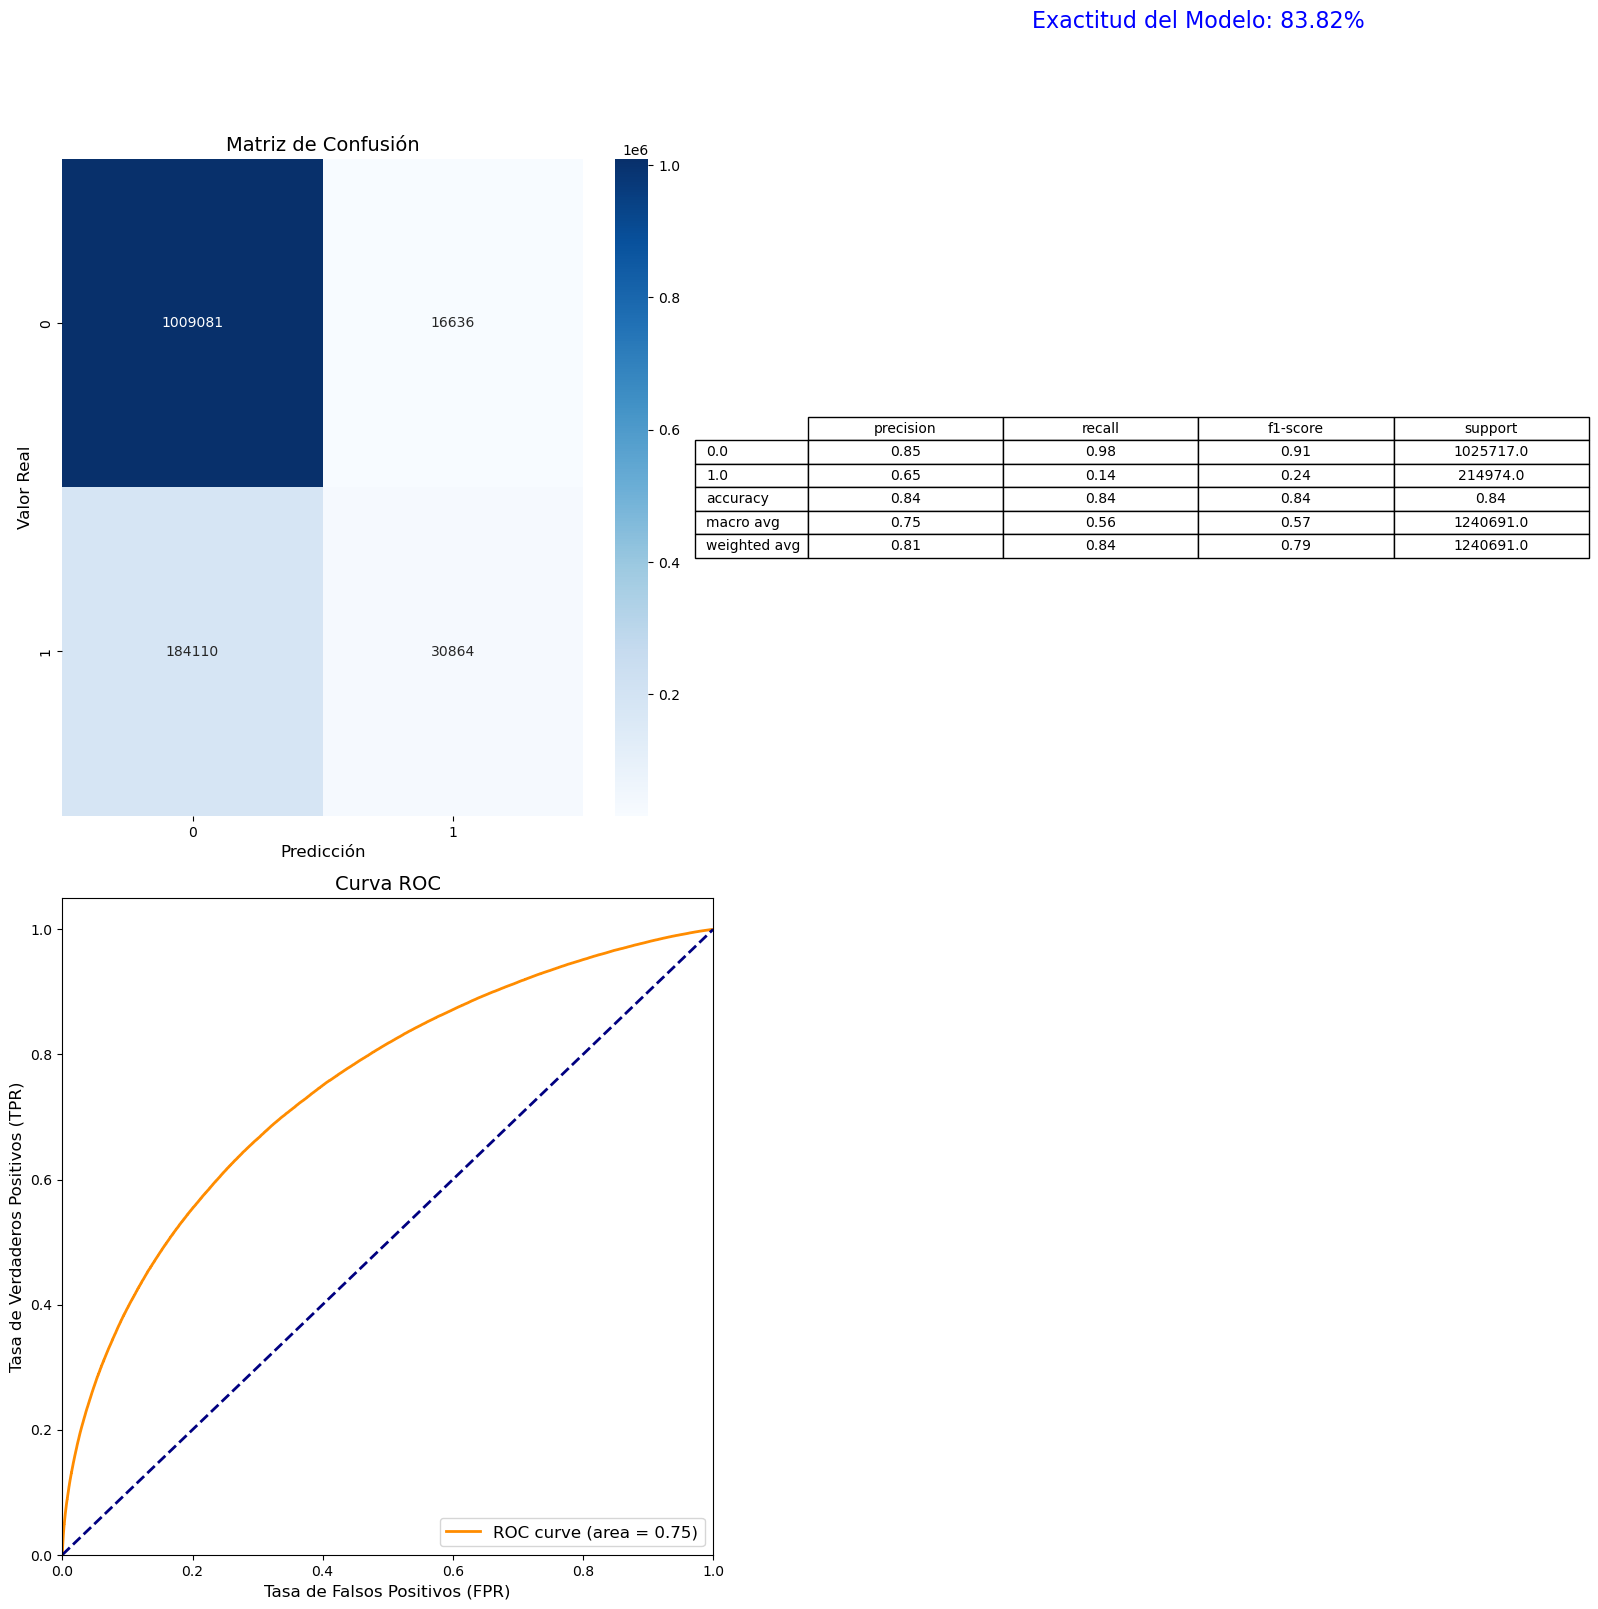

In [240]:
'''# Crear el modelo de XGBoost
xgb_clasificador = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
)

# Entrenar el modelo con los datos de entrenamiento
xgb_clasificador.fit(X_train_with_outliers_norm, y_train)

# Predecir en el conjunto de prueba
y_pred = xgb_clasificador.predict(X_test_with_outliers_norm)
y_pred_proba = xgb_clasificador.predict_proba(X_test_with_outliers_norm)[:, 1]

# Calcular resultados
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, output_dict=True)
accuracy = accuracy_score(y_test, y_pred)

# Calcular la curva ROC y el valor AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Crear el DataFrame para el reporte de clasificación y redondear a 2 decimales
classification_df = pd.DataFrame(classification_rep).transpose().round(2)

# Crear el grafico
fig, ax = plt.subplots(2, 2, figsize=(16, 16))

# Matriz de confusion
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=ax[0, 0])
ax[0, 0].set_title("Matriz de Confusión", fontsize=14)
ax[0, 0].set_xlabel("Predicción", fontsize=12)
ax[0, 0].set_ylabel("Valor Real", fontsize=12)

# Reporte de clasificacion
ax[0, 1].axis("tight")
ax[0, 1].axis("off")

# Accuracy
exact_text = f"Exactitud del Modelo: {accuracy * 100:.2f}%"
ax[0, 1].text(
    0.5, 1.2, exact_text, fontsize=16, color="blue", ha="center", transform=ax[0, 1].transAxes
)

# Reporte de clasificación
table = ax[0, 1].table(
    cellText=classification_df.values,
    colLabels=classification_df.columns,
    rowLabels=classification_df.index,
    loc="center",
    cellLoc="center",
    colLoc="center",
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)  # Escalar la tabla para mejor visualización

# Curva ROC
ax[1, 0].plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
ax[1, 0].plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
ax[1, 0].set_xlim([0.0, 1.0])
ax[1, 0].set_ylim([0.0, 1.05])
ax[1, 0].set_title("Curva ROC", fontsize=14)
ax[1, 0].set_xlabel("Tasa de Falsos Positivos (FPR)", fontsize=12)
ax[1, 0].set_ylabel("Tasa de Verdaderos Positivos (TPR)", fontsize=12)
ax[1, 0].legend(loc="lower right", fontsize=12)

# Subplot 4 vacio
ax[1, 1].axis("off")

# Ajustar diseno general
plt.tight_layout()
plt.show()'''

#### 8.1.1 - IMPORTANCIA DE CARACTERISTICAS

In [241]:
'''# Crear la matriz DMatrix de XGBoost
dtrain = xgb.DMatrix(X_train_with_outliers_norm, label=y_train)
dtest = xgb.DMatrix(X_test_with_outliers_norm, label=y_test)

# Configurar hiperparámetros
params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "max_depth": 6,
    "eta": 0.1,
    "scale_pos_weight": sum(y_train == 0) / sum(y_train == 1)
}

# Entrenar el modelo
bst = xgb.train(params, dtrain, num_boost_round=100)'''

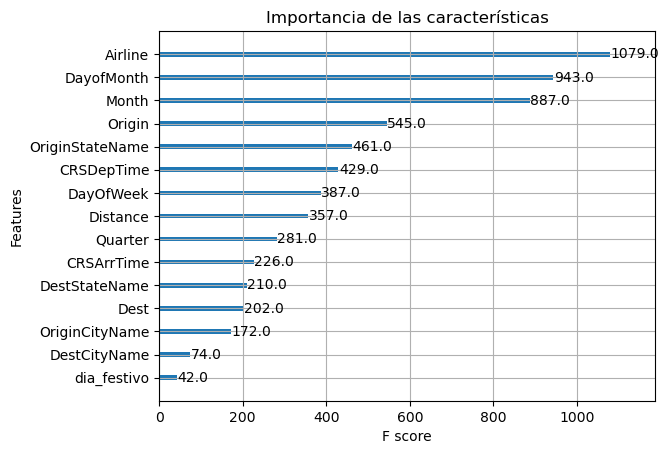

In [242]:
'''xgb.plot_importance(bst)
plt.title("Importancia de las características")
plt.show()'''

### 8.2 - MODELO XGBOOST CLASIFICACION BINARIA CON "SMOTE" ( ACCURACY 77,55% | -FN / +FP )


c:\Users\manue\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:44:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


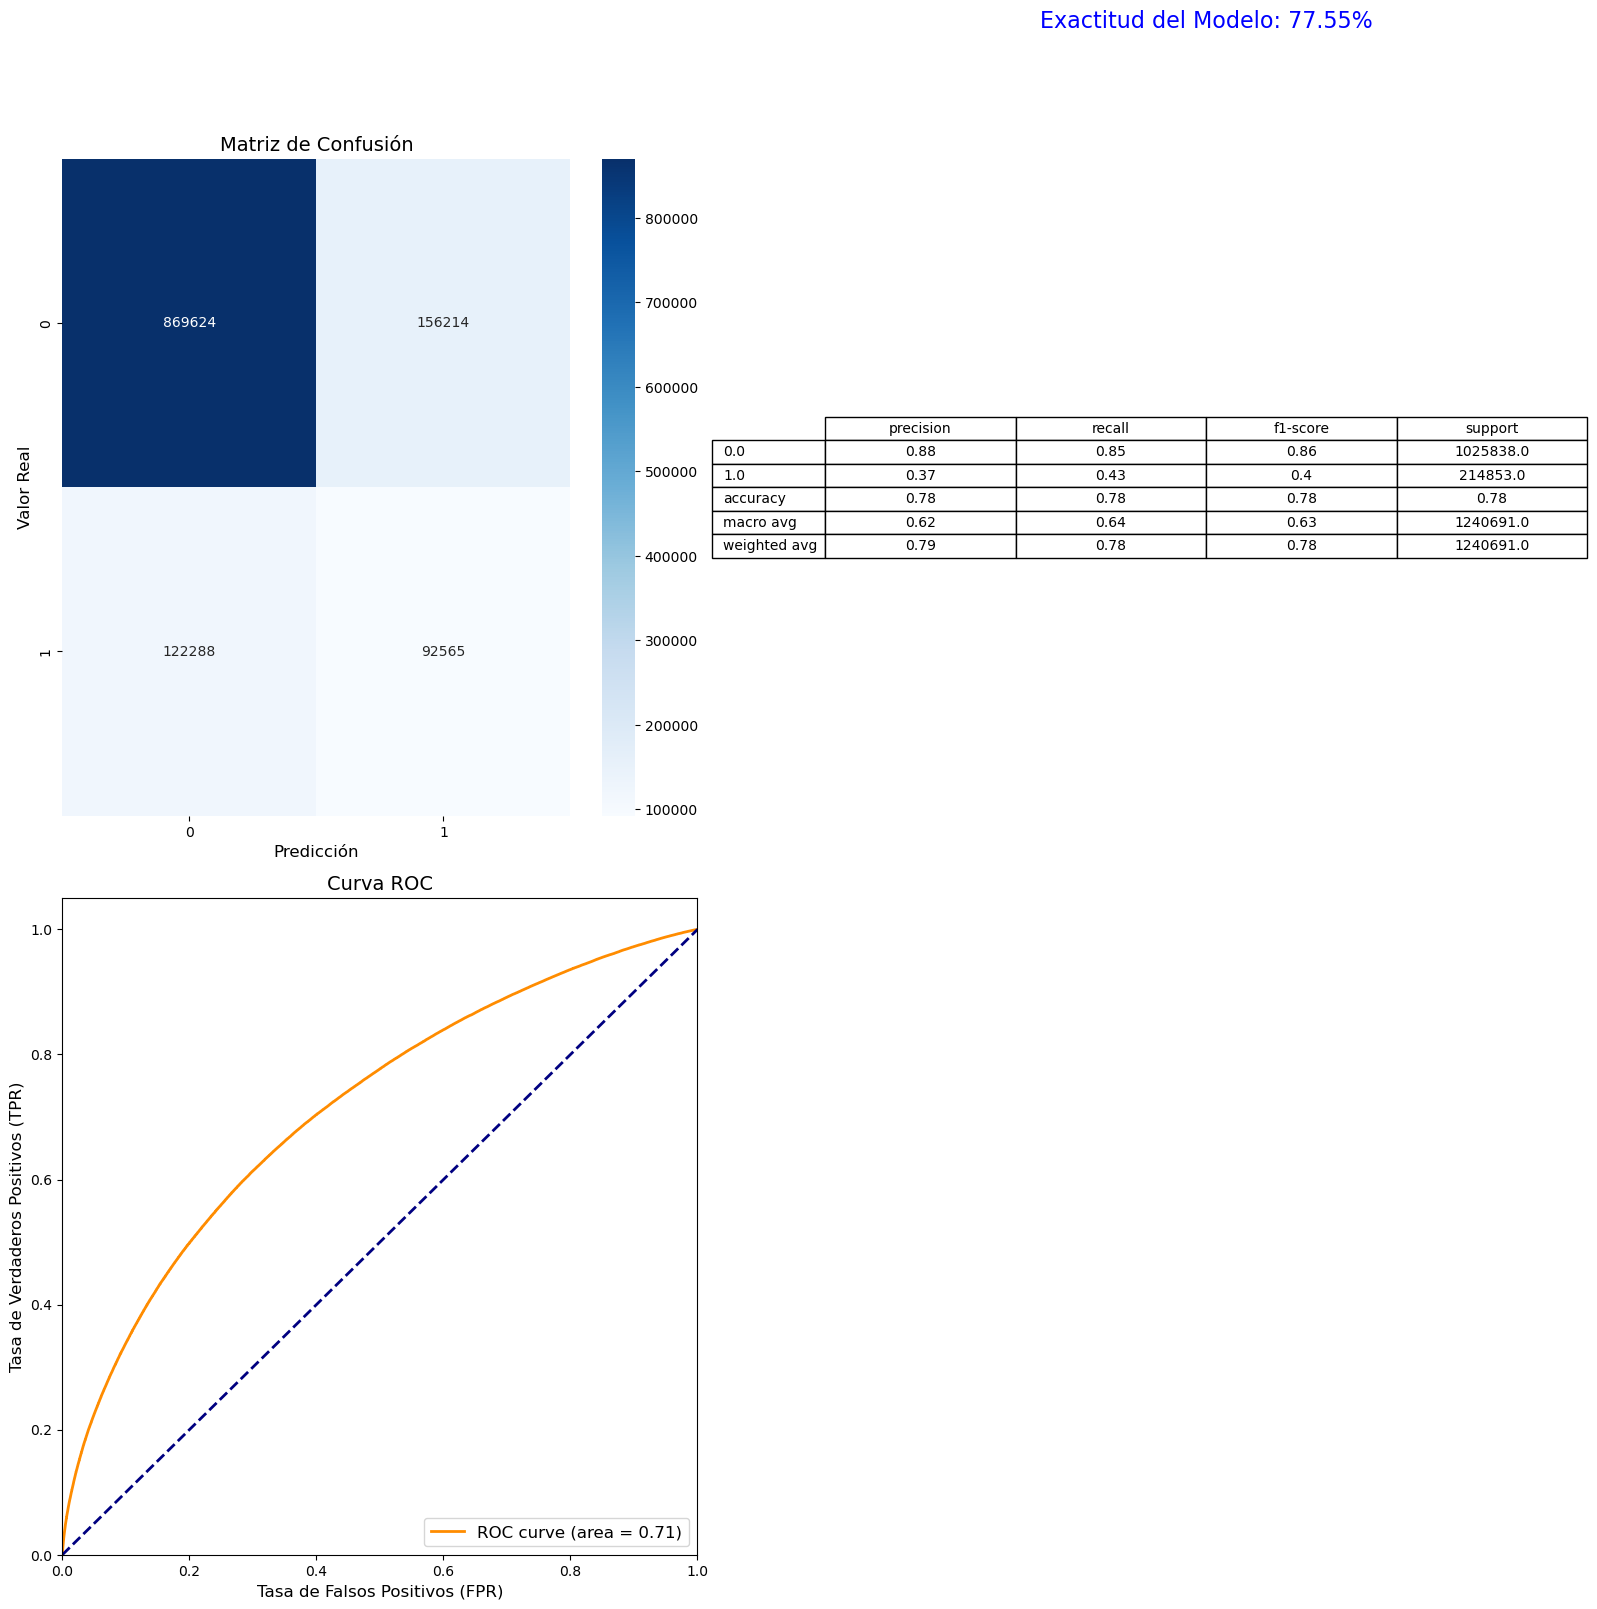

In [244]:
'''# Aplicar SMOTE para balancear las clases en el conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_with_outliers_norm_balanced, y_train_balanced = smote.fit_resample(X_train_with_outliers_norm, y_train)

# Crear el modelo de XGBoost
xgb_clasificador = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
)

# Entrenar el modelo con los datos de entrenamiento balanceados
xgb_clasificador.fit(X_train_with_outliers_norm_balanced, y_train_balanced)

# Predecir en el conjunto de prueba
y_pred_clf = xgb_clasificador.predict(X_test_with_outliers_norm)
y_pred_proba_clf = xgb_clasificador.predict_proba(X_test_with_outliers_norm)[:, 1]

# Calcular resultados
conf_matrix = confusion_matrix(y_test, y_pred_clf)
classification_rep = classification_report(y_test, y_pred_clf, output_dict=True)
accuracy = accuracy_score(y_test, y_pred_clf)

# Calcular la curva ROC y el valor AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_clf)
roc_auc = auc(fpr, tpr)

# Crear el DataFrame para el reporte de clasificación y redondear a 2 decimales
classification_df = pd.DataFrame(classification_rep).transpose().round(2)

# Crear el grafico
fig, ax = plt.subplots(2, 2, figsize=(16, 16))

# Matriz de confusion
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=ax[0, 0])
ax[0, 0].set_title("Matriz de Confusión", fontsize=14)
ax[0, 0].set_xlabel("Predicción", fontsize=12)
ax[0, 0].set_ylabel("Valor Real", fontsize=12)

# Reporte de clasificación 
ax[0, 1].axis("tight")
ax[0, 1].axis("off")

# Accuracy
exact_text = f"Exactitud del Modelo: {accuracy * 100:.2f}%"
ax[0, 1].text(
    0.5, 1.2, exact_text, fontsize=16, color="blue", ha="center", transform=ax[0, 1].transAxes
)

# Reporte de clasificaciOn
table = ax[0, 1].table(
    cellText=classification_df.values,
    colLabels=classification_df.columns,
    rowLabels=classification_df.index,
    loc="center",
    cellLoc="center",
    colLoc="center",
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)  # Escalar la tabla para mejor visualización

# Curva ROC
ax[1, 0].plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
ax[1, 0].plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
ax[1, 0].set_xlim([0.0, 1.0])
ax[1, 0].set_ylim([0.0, 1.05])
ax[1, 0].set_title("Curva ROC", fontsize=14)
ax[1, 0].set_xlabel("Tasa de Falsos Positivos (FPR)", fontsize=12)
ax[1, 0].set_ylabel("Tasa de Verdaderos Positivos (TPR)", fontsize=12)
ax[1, 0].legend(loc="lower right", fontsize=12)

# Subplot 4 vacío
ax[1, 1].axis("off")

# Ajustar diseno general
plt.tight_layout()
plt.show()
'''

### 8.3 - MODELO XGBOOST CLASIFICACION BINARIA CON GRIDSEACRHCV (ACCURACY XX,XX% | -FN / +FP )

In [ ]:
'''
# Definir el modelo base
xgb_clasificador = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
)

# Hiperparametros
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

# Configurar el GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_clasificador,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Entrenar el GridSearchCV con los datos de entrenamiento
grid_search.fit(X_train_with_outliers_norm, y_train)

# Obtener el mejor modelo y los mejores hiperparametros
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print(f"Mejores hiperparámetros: {best_params}")

# Predecir en el conjunto de prueba usando el mejor modelo
y_pred_clf = best_model.predict(X_test_with_outliers_norm)
y_pred_proba_clf = best_model.predict_proba(X_test_with_outliers_norm)[:, 1]

# Calcular resultados
conf_matrix = confusion_matrix(y_test, y_pred_clf)
classification_rep = classification_report(y_test, y_pred_clf, output_dict=True)
accuracy = accuracy_score(y_test, y_pred_clf)

# Calcular la curva ROC y el valor AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_clf)
roc_auc = auc(fpr, tpr)

# Crear el DataFrame para el reporte de clasificación y redondear a 2 decimales
classification_df = pd.DataFrame(classification_rep).transpose().round(2)

# Crear el grafico
fig, ax = plt.subplots(2, 2, figsize=(16, 16))

# Matriz de confusion
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=ax[0, 0])
ax[0, 0].set_title("Matriz de Confusión", fontsize=14)
ax[0, 0].set_xlabel("Predicción", fontsize=12)
ax[0, 0].set_ylabel("Valor Real", fontsize=12)

# Reporte de clasificacion
ax[0, 1].axis("tight")
ax[0, 1].axis("off")

# Accuracy
exact_text = f"Exactitud del Modelo: {accuracy * 100:.2f}%"
ax[0, 1].text(
    0.5, 1.2, exact_text, fontsize=16, color="blue", ha="center", transform=ax[0, 1].transAxes
)

# Reporte de clasificación
table = ax[0, 1].table(
    cellText=classification_df.values,
    colLabels=classification_df.columns,
    rowLabels=classification_df.index,
    loc="center",
    cellLoc="center",
    colLoc="center",
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)  # Escalar la tabla para mejor visualización

# Curva ROC
ax[1, 0].plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
ax[1, 0].plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
ax[1, 0].set_xlim([0.0, 1.0])
ax[1, 0].set_ylim([0.0, 1.05])
ax[1, 0].set_title("Curva ROC", fontsize=14)
ax[1, 0].set_xlabel("Tasa de Falsos Positivos (FPR)", fontsize=12)
ax[1, 0].set_ylabel("Tasa de Verdaderos Positivos (TPR)", fontsize=12)
ax[1, 0].legend(loc="lower right", fontsize=12)

# Subplot 4 vacio
ax[1, 1].axis("off")

# Ajustar diseno general
plt.tight_layout()
plt.show()
'''

Fitting 3 folds for each of 108 candidates, totalling 324 fits


MemoryError: Unable to allocate 164. MiB for an array with shape (13, 1654255) and data type int64

### 8.4 - MODELO XGBOOST CLASIFICACION BINARIA CON RANDOMSEARCHCV (ACCURACY 84,48% | -FN / +FP)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\manue\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:32:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Mejores hiperparámetros: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.8}


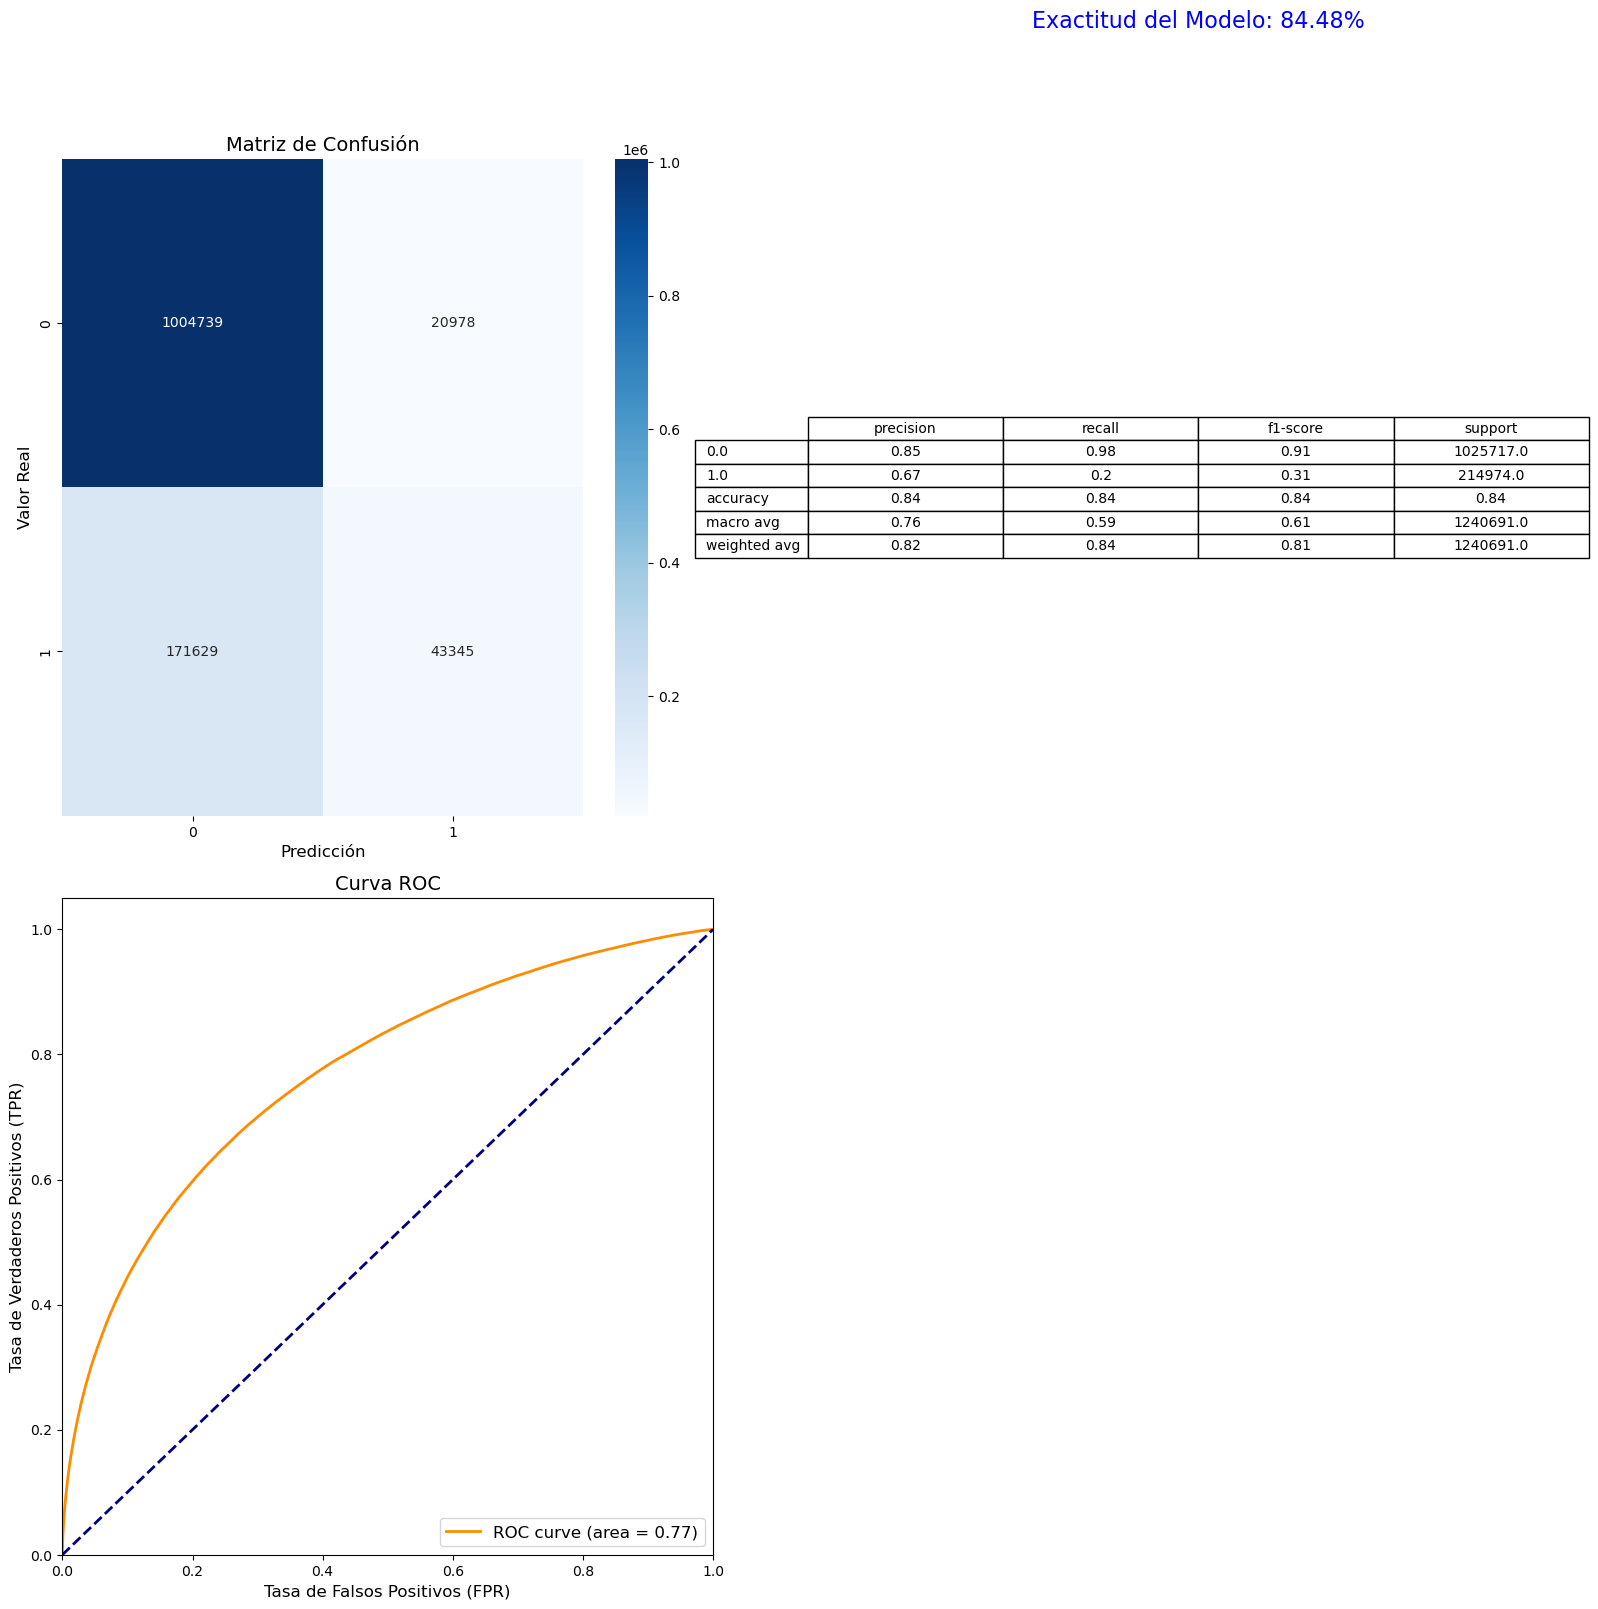

In [97]:
# Definir el modelo base
xgb_clasificador = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
)

# Hiperparametros
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
}

# Configurar el RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_clasificador,
    param_distributions=param_dist,
    scoring='roc_auc',
    n_iter=10,  # Número de combinaciones a probar
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Entrenar el RandomizedSearchCV con los datos de entrenamiento
random_search.fit(X_train_with_outliers_norm, y_train)

# Obtener el mejor modelo y los mejores hiperparámetros
best_model = random_search.best_estimator_
best_params = random_search.best_params_
print(f"Mejores hiperparámetros: {best_params}")

# Predecir en el conjunto de prueba usando el mejor modelo
y_pred_clf = best_model.predict(X_test_with_outliers_norm)
y_pred_proba_clf = best_model.predict_proba(X_test_with_outliers_norm)[:, 1]

# Calcular resultados
conf_matrix = confusion_matrix(y_test, y_pred_clf)
classification_rep = classification_report(y_test, y_pred_clf, output_dict=True)
accuracy = accuracy_score(y_test, y_pred_clf)

# Calcular la curva ROC y el valor AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_clf)
roc_auc = auc(fpr, tpr)

# Crear el DataFrame para el reporte de clasificación y redondear a 2 decimales
classification_df = pd.DataFrame(classification_rep).transpose().round(2)

# Grafico
fig, ax = plt.subplots(2, 2, figsize=(16, 16))

# Matriz de confusion
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=ax[0, 0])
ax[0, 0].set_title("Matriz de Confusión", fontsize=14)
ax[0, 0].set_xlabel("Predicción", fontsize=12)
ax[0, 0].set_ylabel("Valor Real", fontsize=12)

# Reporte de clasificacion
ax[0, 1].axis("tight")
ax[0, 1].axis("off")

# Accuracy
exact_text = f"Accruracy del Modelo: {accuracy * 100:.2f}%"
ax[0, 1].text(
    0.5, 1.2, exact_text, fontsize=16, color="blue", ha="center", transform=ax[0, 1].transAxes
)

# Reporte de clasificacion
table = ax[0, 1].table(
    cellText=classification_df.values,
    colLabels=classification_df.columns,
    rowLabels=classification_df.index,
    loc="center",
    cellLoc="center",
    colLoc="center",
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)  

# Curva ROC
ax[1, 0].plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
ax[1, 0].plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
ax[1, 0].set_xlim([0.0, 1.0])
ax[1, 0].set_ylim([0.0, 1.05])
ax[1, 0].set_title("Curva ROC", fontsize=14)
ax[1, 0].set_xlabel("Tasa de Falsos Positivos (FPR)", fontsize=12)
ax[1, 0].set_ylabel("Tasa de Verdaderos Positivos (TPR)", fontsize=12)
ax[1, 0].legend(loc="lower right", fontsize=12)

# Subplot 4 vacio
ax[1, 1].axis("off")

# Ajustar diseno
plt.tight_layout()
plt.show()

### 8.5 - GUARDANDO EL MODELO

In [99]:
with open('../models/best_model_xgb_subsample_1.0_n_estimators_200_max_depth_10_learning_rate_0.2_gamma_0.1_colsample_bytree_0.8.pkl', 'wb') as file:
    dump(best_model, file)

print("El modelo se ha guardado exitosamente en 'best_model_xgb_subsample_1.0_n_estimators_200_max_depth_10_learning_rate_0.2_gamma_0.1_colsample_bytree_0.8.pkl'.")

El modelo se ha guardado exitosamente en 'best_model_xgb.pkl'.
